In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import os 
import cv2
import pickle
import pandas as pd
import itertools
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import preprocess_input

%matplotlib inline

2025-03-24 14:57:34.728439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 14:57:34.730738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:57:34.743445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:57:34.762867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742795854.782367  251907 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742795854.78

In [2]:
path = "./face_shape_classification/"

X_train = np.asarray(pickle.load(open(path + "X_train_gray.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_gray.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_gray.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_gray.pickle","rb")))

In [3]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (3981, 224, 224, 1)
y_train shape (3981, 5)
--------------------
X_test shape (998, 224, 224, 1)
y_test shape (998, 5)


In [4]:
# X_train이나 X_test의 데이터 타입 확인
print(f"X_train 데이터 타입: {X_train.dtype}")
print(f"X_test 데이터 타입: {X_test.dtype}")

X_train 데이터 타입: float64
X_test 데이터 타입: float64


In [5]:
# train데이터와 test 데이터 전부 활용 
import numpy as np
import cv2
import mediapipe as mp

#경고무시
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='libEGL')

# MediaPipe 얼굴 랜드마크 추출 설정
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, 
                                  min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 흑백 이미지를 RGB로 변환하는 함수
def gray_to_rgb(images):
    # float64 -> uint8로 변환 (0~255 범위로)
    images_uint8 = np.clip(images * 255, 0, 255).astype(np.uint8)
    
    # 이미지를 RGB로 변환
    images_rgb = np.array([cv2.cvtColor(img.squeeze(axis=-1), cv2.COLOR_GRAY2RGB) for img in images_uint8])
    return images_rgb

# X_train과 X_test가 float64일 경우 이를 uint8로 변환
X_train_rgb = gray_to_rgb(X_train)  # (N, 224, 224, 1) -> (N, 224, 224, 3)
X_test_rgb = gray_to_rgb(X_test)  # (N, 224, 224, 1) -> (N, 224, 224, 3)

# 훈련 데이터에 대해 랜드마크 추출
train_landmarks_list = []
for img in X_train_rgb:
    # 이미지를 BGR 형식으로 변환
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # 랜드마크 추출
    results = face_mesh.process(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # RGB로 변환 후 처리

    # 얼굴 랜드마크가 추출되었을 때만 저장
    if results.multi_face_landmarks:
        train_landmarks_list.append(results.multi_face_landmarks[0])

# 테스트 데이터에 대해 랜드마크 추출
test_landmarks_list = []
for img in X_test_rgb:
    # 이미지를 BGR 형식으로 변환
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # 랜드마크 추출
    results = face_mesh.process(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # RGB로 변환 후 처리

    # 얼굴 랜드마크가 추출되었을 때만 저장
    if results.multi_face_landmarks:
        test_landmarks_list.append(results.multi_face_landmarks[0])

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1742795871.121907  251993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742795871.134029  251993 inference_feedback_manager.cc:114] Feedback ma

In [6]:
# 랜드마크 리스트의 길이 확인
print(f"Number of train samples: {len(train_landmarks_list)}")
print(f"Number of test samples: {len(test_landmarks_list)}")

Number of train samples: 3977
Number of test samples: 996


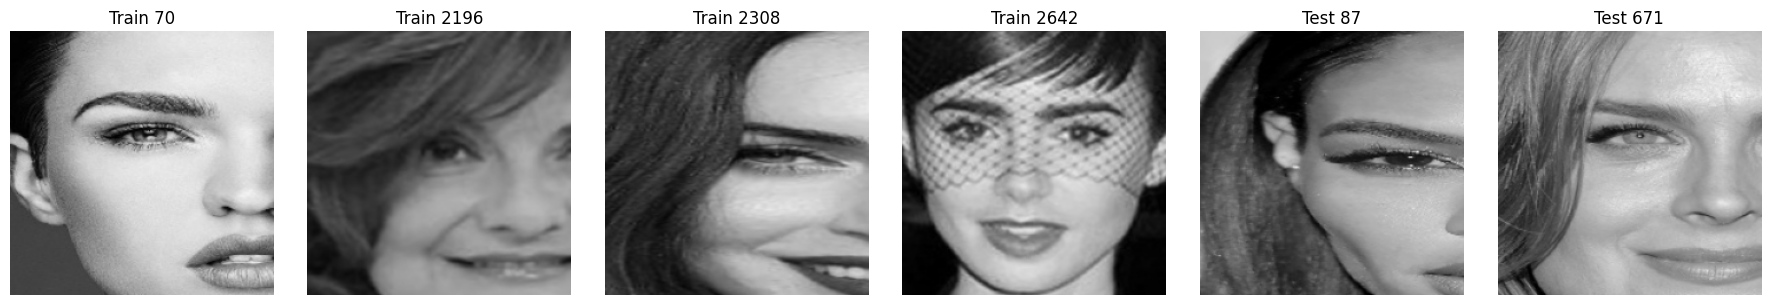

In [9]:
# 랜드마크가 추출되지 않은 train 데이터에서 이미지 찾기
no_landmark_train_images = []
no_landmark_test_images = []

# train 데이터에서 랜드마크가 추출되지 않은 이미지 찾기
for i, img in enumerate(X_train_rgb):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    results = face_mesh.process(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # RGB로 변환 후 처리
    if not results.multi_face_landmarks:  # 랜드마크가 추출되지 않은 경우
        no_landmark_train_images.append((img, i))  # 이미지와 인덱스를 저장

# test 데이터에서 랜드마크가 추출되지 않은 이미지 찾기
for i, img in enumerate(X_test_rgb):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    results = face_mesh.process(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # RGB로 변환 후 처리
    if not results.multi_face_landmarks:  # 랜드마크가 추출되지 않은 경우
        no_landmark_test_images.append((img, i))  # 이미지와 인덱스를 저장
        
# 시각화
num_images = len(no_landmark_train_images) + len(no_landmark_test_images)
fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))

# train 이미지 시각화
for i, (image, idx) in enumerate(no_landmark_train_images):
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Train {idx}")  # 이미지 인덱스 표시

# test 이미지 시각화
for i, (image, idx) in enumerate(no_landmark_test_images):
    axes[len(no_landmark_train_images) + i].imshow(image)
    axes[len(no_landmark_train_images) + i].axis('off')
    axes[len(no_landmark_train_images) + i].set_title(f"Test {idx}")
    
plt.tight_layout()
plt.show()

In [10]:
print(len(y_train), len(y_test))

3981 998


In [11]:
#랜드마크 추출되지 않은 이미지들에 해당하는 라벨도 제거

# no_landmark_train_images에서 랜드마크가 추출되지 않은 이미지들의 인덱스만 추출
no_landmark_train_indexes = [index for _, index in no_landmark_train_images]
no_landmark_test_indexes  = [index for _, index in no_landmark_test_images]

# y_train과 y_test에서 랜드마크가 추출되지 않은 이미지들 제외
y_train = np.delete(y_train, no_landmark_train_indexes, axis=0)
y_test = np.delete(y_test, no_landmark_test_indexes, axis=0)

# 필터링된 데이터 크기 확인
print(f"Filtered y_train size: {len(y_train)}")
print(f"Filtered y_test size: {len(y_test)}")

Filtered y_train size: 3977
Filtered y_test size: 996


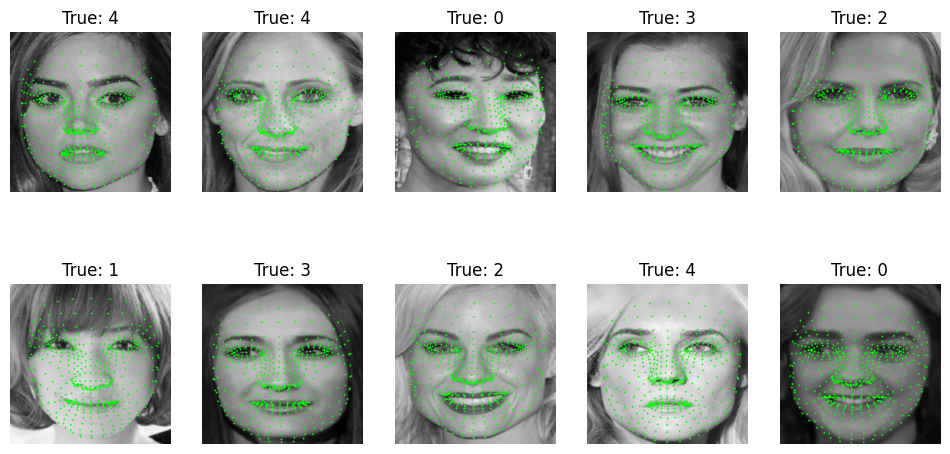

In [13]:
# 시각화 
# 랜덤으로 10개 샘플 선택
import random
random_indices = random.sample(range(len(X_test)), 10)
random_images = [X_test_rgb[i] for i in random_indices]
random_labels = [y_test[i] for i in random_indices]

# 랜드마크 추출 및 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    image = random_images[i]
    
    # MediaPipe에 입력할 이미지 준비 (RGB 이미지만 입력 가능)
    img_rgb = image.astype(np.uint8)

    # 랜드마크 추출
    results = face_mesh.process(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형태
    
    # 이미지에 랜드마크 그리기
    if results.multi_face_landmarks:
        for landmarks in results.multi_face_landmarks:
            for landmark in landmarks.landmark:
                x = int(landmark.x * 224)  # 이미지 크기 (224x224) 비율로 변환
                y = int(landmark.y * 224)  # 이미지 크기 (224x224) 비율로 변환
                cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)

    # 이미지를 matplotlib로 표시
    axes[i].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"True: {np.argmax(random_labels[i])}")  # 실제 레이블 표시

plt.show()

In [14]:
# CNN 데이터 전처리 
# 형태 변환 
# 하나의 이미지(하나의 얼굴)에서 총 468개의 랜드마크 추출됨. 

# 전처리 함수: 각 이미지에 대해 468개의 랜드마크 (x, y, z) 좌표 생성
def preprocess_landmarks(landmarks_list):
    landmarks = []
    for landmarks_per_image in landmarks_list:
        # 각 랜드마크에서 x, y, z 값을 추출하여 (468, 3) 배열 생성
        image_landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_per_image.landmark])
        landmarks.append(image_landmarks)
    return np.array(landmarks)

# 훈련 데이터와 테스트 데이터 전처리
X_train_landmarks = preprocess_landmarks(train_landmarks_list)  # (3977, 468, 3)
X_test_landmarks = preprocess_landmarks(test_landmarks_list)    # (996, 468, 3)

# 결과 확인
print(f"X_train_landmarks shape: {X_train_landmarks.shape}")  # (3977, 468, 3)
print(f"X_test_landmarks shape: {X_test_landmarks.shape}")    # (996, 468, 3)

X_train_landmarks shape: (3977, 468, 3)
X_test_landmarks shape: (996, 468, 3)


In [14]:
print(train_landmarks_list[:10])

[landmark {
  x: 0.515876651
  y: 0.739759445
  z: -0.0717411041
}
landmark {
  x: 0.518669844
  y: 0.646860123
  z: -0.192400813
}
landmark {
  x: 0.516743
  y: 0.670347095
  z: -0.0882523134
}
landmark {
  x: 0.488644272
  y: 0.524401307
  z: -0.16667293
}
landmark {
  x: 0.519211531
  y: 0.611813605
  z: -0.210849524
}
landmark {
  x: 0.519386351
  y: 0.562004805
  z: -0.204616874
}
landmark {
  x: 0.51971364
  y: 0.438237339
  z: -0.13167502
}
landmark {
  x: 0.249137789
  y: 0.401650071
  z: 0.00300110225
}
landmark {
  x: 0.52126205
  y: 0.357079029
  z: -0.124487311
}
landmark {
  x: 0.522374451
  y: 0.311089844
  z: -0.14254345
}
landmark {
  x: 0.521775723
  y: 0.102743
  z: -0.14356856
}
landmark {
  x: 0.515880287
  y: 0.754895806
  z: -0.0645724311
}
landmark {
  x: 0.515660524
  y: 0.76353687
  z: -0.0514716096
}
landmark {
  x: 0.515352845
  y: 0.764369965
  z: -0.0340881646
}
landmark {
  x: 0.516737521
  y: 0.781411052
  z: -0.0267646406
}
landmark {
  x: 0.516594589
  

In [15]:
#cnn모델은 정규화된 데이터를 더 잘 학습시켜줌 
from sklearn.preprocessing import StandardScaler

# 표준화 및 정규화 
def normalize_landmarks(landmarks_data):
    scaler = StandardScaler()
    # 랜드마크 데이터를 (N, 468 * 3) 형태로 변환
    landmarks_data = landmarks_data.reshape((landmarks_data.shape[0], -1))
    normalized_data = scaler.fit_transform(landmarks_data)  # 데이터 정규화
    return normalized_data

X_train_normalized = normalize_landmarks(X_train_landmarks)  # (3977, 468*3)
X_test_normalized = normalize_landmarks(X_test_landmarks)    # (996, 468*3)

In [16]:
print(X_train_normalized.shape)

(3977, 1404)


In [17]:
#다시 정규화

# 정규화 후 (3977, 468, 3) 형태 유지
X_train_normalized = X_train_landmarks / np.max(X_train_landmarks, axis=(0, 1), keepdims=True)
X_test_normalized = X_test_landmarks / np.max(X_test_landmarks, axis=(0, 1), keepdims=True)

In [18]:
print(X_train_normalized.shape)

(3977, 468, 3)


In [19]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Sequential 모델 정의
model = Sequential()

# 첫 번째 레이어는 Input 레이어로 데이터를 정의
model.add(Input(shape=(468, 3)))

# 이후 Conv1D 레이어 등 다른 레이어 추가
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# 세부 레이어 추가
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten과 Dense 레이어
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(5, activation='softmax'))

model.summary()

2025-03-24 15:01:11.887292: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 466, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 233, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 231, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 115, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       942,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 949,381 (3.62 MB)

 Trainable params: 949,381 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print("First few samples in y_train:")
print(y_train[:10])  # y_train의 첫 10개 샘플 확인

print("First few samples in y_test:")
print(y_test[:10])  # y_test의 첫 10개 샘플 확인

First few samples in y_train:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
First few samples in y_test:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [34]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

model = Sequential()

# 첫 번째 레이어 (Conv1D)
model.add(Input(shape=(468, 3)))

# 첫 번째 Conv1D 레이어
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 두 번째 Conv1D 레이어
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 세 번째 Conv1D 레이어 추가
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten 후 Dense 레이어
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(5, activation='softmax'))  # 5개의 클래스로 분류

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_data=(X_test_normalized, y_test), callbacks=[early_stopping])

# 모델 평가
loss, accuracy = model.evaluate(X_test_normalized, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.1958 - loss: 1.8236 - val_accuracy: 0.1998 - val_loss: 1.6097
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.1857 - loss: 1.6118 - val_accuracy: 0.1998 - val_loss: 1.6100
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.1908 - loss: 1.6111 - val_accuracy: 0.2008 - val_loss: 1.6100
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.1971 - loss: 1.6104 - val_accuracy: 0.1998 - val_loss: 1.6098
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.2022 - loss: 1.6102 - val_accuracy: 0.1998 - val_loss: 1.6100
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.1998 - loss: 1.6107 - val_accuracy: 0.1998 - val_loss: 1.6098
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2000 - loss: 1.6093
Test Loss: 1.6097451448440552
Test Accuracy: 0.19979919493198395


In [ ]:
##데이터 증강 

In [20]:
import numpy as np

# 랜드마크 회전 함수
def rotate_landmarks(landmarks, angle):
    """
    랜드마크 좌표들을 주어진 각도만큼 회전시키는 함수
    """
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])
    
    # 각 랜드마크에 대해 회전 적용
    rotated_landmarks = []
    for landmark in landmarks:
        rotated = np.dot(rotation_matrix, landmark[:2])  # x, y 회전만 적용
        rotated_landmarks.append(np.array([rotated[0], rotated[1], landmark[2]]))  # z는 그대로
    return np.array(rotated_landmarks)

# 랜드마크 이동 함수
def translate_landmarks(landmarks, tx, ty):
    """
    랜드마크 좌표들을 tx, ty 만큼 이동시키는 함수
    """
    translated_landmarks = []
    for landmark in landmarks:
        translated_landmarks.append(landmark + np.array([tx, ty, 0]))  # z는 그대로
    return np.array(translated_landmarks)

# 랜드마크 좌우 반전 함수
def flip_landmarks(landmarks):
    """
    랜드마크 좌표들을 좌우 반전시키는 함수
    """
    flipped_landmarks = []
    for landmark in landmarks:
        flipped_landmarks.append(np.array([-landmark[0], landmark[1], landmark[2]]))  # x를 반전
    return np.array(flipped_landmarks)

# 랜드마크 데이터 증강 함수
def augment_landmarks(landmarks_list):
    augmented_data = []
    
    for landmarks_per_image in landmarks_list:
        # 각 랜드마크 객체에서 x, y, z 좌표를 추출하여 numpy 배열로 변환
        landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_per_image.landmark])

        # 랜드마크 데이터 증강 (회전, 이동, 반전)
        augmented_data.append(rotate_landmarks(landmarks, angle=30))  # 30도 회전
        augmented_data.append(translate_landmarks(landmarks, tx=0.1, ty=0.1))  # 좌표 이동
        augmented_data.append(flip_landmarks(landmarks))  # 좌우 반전
    
    return augmented_data

# `train_landmarks_list`에 대해 데이터 증강 적용
augmented_train_landmarks = augment_landmarks(train_landmarks_list)  # train_landmarks_list에서 증강

# 증강된 데이터가 numpy 형식으로 변환되어야 한다
augmented_train_landmarks = np.array(augmented_train_landmarks)  # (증강된 데이터 수, 468, 3)

def normalize_landmarks(landmarks_data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # 랜드마크 데이터를 (N, 468 * 3) 형태로 변환
    landmarks_data = landmarks_data.reshape((landmarks_data.shape[0], -1))
    normalized_data = scaler.fit_transform(landmarks_data)  # 데이터 정규화
    return normalized_data

augmented_X_train_landmarks = normalize_landmarks(augmented_train_landmarks)  # (증강된 데이터 수, 468*3)

In [25]:
# X_train의 데이터 증강 비율 계산
augmentation_factor = len(augmented_X_train_landmarks) // len(X_train_landmarks)

# y_train을 augmented_X_train_landmarks의 샘플 수에 맞게 반복
augmented_y_train = np.tile(y_train, (augmentation_factor, 1))

In [33]:
# 증강된 데이터로 모델 훈련
# augmented_X_train_landmarks의 shape 확인 후 reshape
augmented_X_train_landmarks = augmented_X_train_landmarks.reshape(-1, 468, 3)

# 훈련
model.fit(augmented_X_train_landmarks, augmented_y_train, epochs=50, batch_size=32, validation_data=(X_test_landmarks, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_landmarks, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.1998 - loss: 1.9799 - val_accuracy: 0.2058 - val_loss: 1.6093
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.1922 - loss: 1.6095 - val_accuracy: 0.1948 - val_loss: 1.6093
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.1981 - loss: 1.6095 - val_accuracy: 0.2058 - val_loss: 1.6093
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.2004 - loss: 1.6096 - val_accuracy: 0.2048 - val_loss: 1.6093
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.1983 - loss: 1.6094 - val_accuracy: 0.2068 - val_loss: 1.6093
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.2018 - loss: 1.6094 - val_accuracy: 0.2048 - val_loss: 1.6093
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2036 - loss: 1.6092
Test Loss: 1.6093120574951172
Test Accuracy: 0.20582328736782074


In [27]:
print(f"augmented_X_train_landmarks shape: {augmented_X_train_landmarks.shape}")
print(f"augmented_y_train shape: {augmented_y_train.shape}")
print(f"augmented_X_test_landmarks shape: {X_test_landmarks.shape}")
print(f"y_test shape: {y_test.shape}")

augmented_X_train_landmarks shape: (11931, 1404)
augmented_y_train shape: (11931, 5)
augmented_X_test_landmarks shape: (996, 468, 3)
y_test shape: (996, 5)


In [7]:
# X_test_rgb의 첫 번째 이미지를 확인
first_image = X_test_rgb[0]  # 첫 번째 이미지 가져오기

# 첫 번째 이미지의 shape과 dtype을 확인
print(f"First image shape: {first_image.shape}")
print(f"First image dtype: {first_image.dtype}")

# 첫 번째 이미지의 채널 개수도 확인 (RGB의 경우 3이어야 합니다)
if len(first_image.shape) == 3 and first_image.shape[2] == 3:
    print("The image has 3 channels (RGB).")
else:
    print("The image does not have 3 channels.")

First image shape: (224, 224, 3)
First image dtype: uint8
The image has 3 channels (RGB).


In [11]:
# OpenCV 버전 확인
print(f"OpenCV version: {cv2.__version__}")

# OpenCV 라이브러리 로드가 정상적으로 이루어졌는지 확인
if cv2.__version__:
    print("OpenCV is successfully installed.")
else:
    print("OpenCV installation failed.")

OpenCV version: 4.11.0
OpenCV is successfully installed.


Gray image shape: (224, 224, 1)
Gray image dtype: int64
Gray image min, max: 128, 128
Gray image after conversion dtype: uint8
Gray image after conversion min, max: 128, 128
RGB image shape: (224, 224, 3)


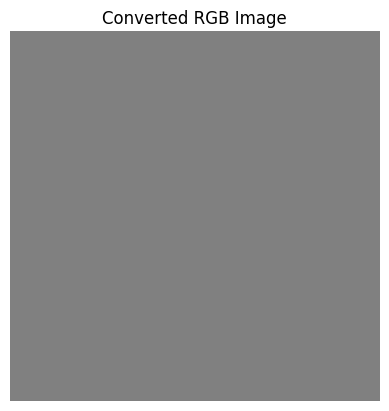

Red channel mean: 128.0
Green channel mean: 128.0
Blue channel mean: 128.0


In [13]:
# 예시: (224, 224, 1) 형식의 흑백 이미지 만들기 (값이 모두 128로 균일한 이미지)
gray_image = np.full((224, 224, 1), 128)  # 모든 픽셀 값이 128인 이미지 생성

# 이미지를 uint8로 변환
gray_image_uint8 = (gray_image).astype(np.uint8)

# 1. 이미지 형태와 타입 확인
print(f"Gray image shape: {gray_image.shape}")
print(f"Gray image dtype: {gray_image.dtype}")
print(f"Gray image min, max: {gray_image.min()}, {gray_image.max()}")
print(f"Gray image after conversion dtype: {gray_image_uint8.dtype}")
print(f"Gray image after conversion min, max: {gray_image_uint8.min()}, {gray_image_uint8.max()}")

# 2. cv2.cvtColor로 변환 시도 (Gray -> RGB)
try:
    rgb_image = cv2.cvtColor(gray_image_uint8.squeeze(axis=-1), cv2.COLOR_GRAY2RGB)  # squeeze로 채널 수 1에서 3으로 변경
    print(f"RGB image shape: {rgb_image.shape}")  # RGB로 변환된 이미지의 형태 확인

    # 3. RGB 이미지 시각화
    plt.imshow(rgb_image)
    plt.title("Converted RGB Image")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error during conversion: {e}")

# 채널 평균값 확인
print("Red channel mean:", rgb_image[:, :, 0].mean())
print("Green channel mean:", rgb_image[:, :, 1].mean())
print("Blue channel mean:", rgb_image[:, :, 2].mean())

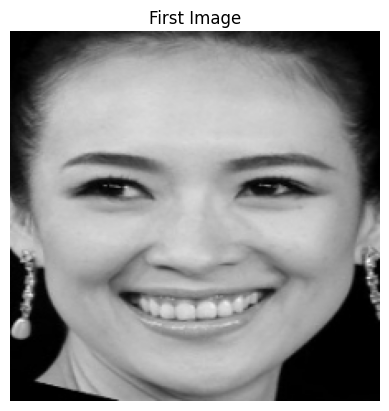

First image shape: (224, 224, 3)
First image dtype: uint8
Red channel mean: 134.6874003507653
Green channel mean: 134.6874003507653
Blue channel mean: 134.6874003507653


In [29]:
# 예시 이미지 (흑백 -> RGB 변환 테스트)
# 이미지를 uint8로 변환하는 함수
def convert_to_uint8(images):
    return np.clip(images * 255, 0, 255).astype(np.uint8)

# 흑백 이미지를 RGB로 변환하는 함수
def gray_to_rgb(images):
    images_rgb = np.array([cv2.cvtColor(img.squeeze(axis=-1), cv2.COLOR_GRAY2RGB) for img in images])  # squeeze로 1채널을 제거하고 변환
    return images_rgb
    
# X_test를 uint8로 변환
X_test_uint8 = convert_to_uint8(X_test)

# X_test를 RGB로 변환
X_test_rgb = gray_to_rgb(X_test_uint8)

# 첫 번째 이미지의 각 채널 평균값 확인
first_image = X_test_rgb[0]

# 이미지를 RGB로 변환하여 시각화
plt.imshow(first_image)
plt.title("First Image")
plt.axis('off')
plt.show()

# RGB 각 채널 평균값 확인 (이제 각 채널 값이 다를 것이다)
print("First image shape:", first_image.shape)
print("First image dtype:", first_image.dtype)

# 각 채널 평균값 확인
print("Red channel mean:", first_image[:, :, 0].mean())
print("Green channel mean:", first_image[:, :, 1].mean())
print("Blue channel mean:", first_image[:, :, 2].mean())